In [48]:
import pandas as pd
import numpy as np
import math
import gc

In [ ]:
seasons = list(range(2009,2019))

# test
# seasons = list(range(2018,2019))

# merge seasons into one complete df
df = pd.DataFrame()
for season in seasons:
    path = './data/nflscrapR-data/play_by_play_data/regular_season/reg_pbp_'+str(season)+'.csv'
    season_df = pd.read_csv(path)
    df = pd.concat([df, season_df], axis=0)
    path = './data/nflscrapR-data/play_by_play_data/post_season/post_pbp_'+str(season)+'.csv'
    post_season_df = pd.read_csv(path)
    df = pd.concat([df, post_season_df], axis=0)
print(df.shape)

print(df['play_type'].unique())
print(list(df))

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (42,166,167,174,175,178,179,182,183,188,189,190,191,203,204,205,231,232,233,238,240,241) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [50]:
def is_first(fdp,fdr):
    return 1 if ((fdp==1) or (fdr==1)) else 0

def nonqb(run, rec):
    no_run = no_rec = False
    if type(run) != str:
        no_run = True
    if type(rec) != str:
        no_rec = True
    if no_run and not no_rec:
        return rec
    elif no_rec and not no_run:
        return run
    return ""

def to_binary(x):
    return 1 if x == 'success' else 0

# make first down column
df['first_down'] = df.apply(lambda row: is_first(row['first_down_pass'],row['first_down_rush']),axis=1)

# make column with rusher/receiver id
df['nonqb_id'] = df.apply(lambda row: nonqb(row['rusher_player_id'], row['receiver_player_id']),axis=1)

# convert two point conversions to binary
df['two_point_conv_result'] = df['two_point_conv_result'].apply(lambda x: to_binary(x))

rop_df = df.loc[(df.play_type == 'pass')|(df.play_type=='run')]

# for index,row in rop_df.iterrows():
#     if row['nonqb_id'] == '':
#         print(row['desc'])

# drop sacks/throwaways
rop_df = rop_df.loc[rop_df.nonqb_id != '']




In [52]:
# group together games and nonqb ids
# games = df.groupby(['game_id','nonqb_id'])['yards_gained','touchdown','fumble','first_down','two_point_conv_result','epa'].sum()
print(len(rop_df))
rop_df['att_count'] = rop_df.groupby(['nonqb_id'])['epa'].transform("count")
# print(rop_df['att_count'])
rop_df = rop_df.loc[rop_df['att_count']>30]

gb = rop_df.groupby(['game_id','nonqb_id'])['yards_gained','complete_pass','touchdown','first_down','two_point_conv_result','fumble','epa'].sum()

ngb = gb.reset_index()
print(ngb.head(10))

322613
      game_id    nonqb_id  yards_gained  complete_pass  touchdown  first_down  \
0  2009091000  00-0017162         103.0            8.0        0.0           3   
1  2009091000  00-0020285           5.0            2.0        0.0           0   
2  2009091000  00-0021982          78.0            7.0        1.0           6   
3  2009091000  00-0022217          36.0            4.0        0.0           3   
4  2009091000  00-0022250          24.0            1.0        0.0           1   
5  2009091000  00-0022924           3.0            0.0        0.0           0   
6  2009091000  00-0023367           8.0            1.0        0.0           1   
7  2009091000  00-0023465          64.0            8.0        0.0           3   
8  2009091000  00-0023612          48.0            5.0        0.0           3   
9  2009091000  00-0024240         131.0            9.0        1.0           8   

   two_point_conv_result  fumble       epa  
0                      0     1.0 -0.648620  
1          

In [62]:
# determine how many runs and receptions there are in a game
rp_count = rop_df.groupby(['game_id'])['epa'].count()
print(rp_count.mean())

117.4247853676745


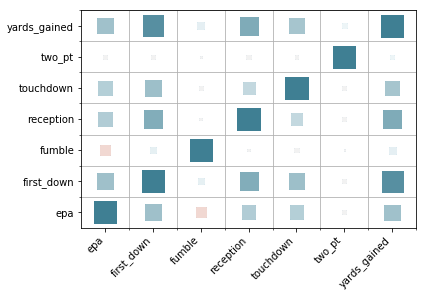

In [53]:
# create correlation viz
# taken from https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec

import matplotlib.pyplot as plt
import seaborn as sns

# Step 1 - Make a scatter plot with square markers, set column names as labels

def heatmap(x, y, color, color_range, size):
    fig, ax = plt.subplots()
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in sorted(x.unique())]
    y_labels = [v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 500
    ax.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, # Vector of square sizes, proportional to size parameter
        marker='s' # Use square as scatterplot marker
    )
    
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    
    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)
    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5]) 
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    
    n_colors = 256 # Use 256 colors for the diverging color palette
    palette = sns.diverging_palette(20, 220, n=n_colors) # Create the palette
    color_min, color_max = color_range # Range of values that will be mapped to the palette, i.e. min and max possible correlation

    def value_to_color(val):
        val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
        ind = int(val_position * (n_colors - 1)) # target index in the color palette
        return palette[ind]

    ax.scatter(
        x=x.map(x_to_num),
        y=y.map(y_to_num),
        s=size * size_scale,
        c=color.apply(value_to_color), # Vector of square color values, mapped to color palette
        marker='s'
    )
    
    fig.savefig('./images/heatmap.png',bbox_inches="tight")
    
ngb = ngb.rename(columns={'complete_pass':'reception','two_point_conv_result':'two_pt'})
cols = ['yards_gained','reception','touchdown','first_down','fumble','two_pt','epa']
data = ngb[cols]
corr = data[cols].corr()
corr = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
corr.columns = ['x', 'y', 'value']
heatmap(
    x=corr['x'],
    y=corr['y'],
    color=corr['value'], 
    color_range=[-1, 1],
    size=corr['value'].abs()
)

# fig.savefig('./images/heatmap.png')



In [77]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


Y = data.epa
X = data.drop(columns='epa')

X_train,X_test,y_train,y_test=train_test_split(X,Y, test_size=0.15, random_state=17)


lasso = Lasso(alpha=0.2)
lasso.fit(X_train,y_train)
train_score=lasso.score(X_train,y_train)
test_score=lasso.score(X_test,y_test)
coeff_used = np.sum(lasso.coef_!=0)

print("Lasso")
print(train_score)
print(test_score)
print(coeff_used)
scaled = lasso.coef_ * (0.1/lasso.coef_[0])
scaled = np.array([round_half(x) for x in scaled])
scaled[0] = 0.1

lasso_df = pd.DataFrame(zip(X.columns, np.round(lasso.coef_,3), scaled),columns=['Stat','Weight','Scaled'])
print(lasso_df[:coeff_used])

lr = LinearRegression()
lr.fit(X_train,y_train)
lr_train_score=lr.score(X_train,y_train)
lr_test_score=lr.score(X_test,y_test)

print("Linear")
print(lr_train_score)
print(lr_test_score)

def round_half(number):
    return round(number * 2) / 2

scaled = lr.coef_ * (0.1/lr.coef_[0])
scaled = np.array([round_half(x) for x in scaled])
scaled[0] = 0.1
print(pd.DataFrame(zip(X.columns, np.round(lr.coef_,3), scaled),columns=['Stat','Weight','Scaled']))

# fgs = df.loc[df.play_type=='field_goal']
# games = fgs.groupby(['game_id','defteam'])['field_goal_attempt','field_goal_result','epa'].sum()

# print(games.head(10))


# punter love... can figure out punter fantasy points


Lasso
0.2735970738689685
0.2552628394804842
5
           Stat  Weight  Scaled
0  yards_gained   0.029     0.1
1     reception   0.099     0.5
2     touchdown   0.414     1.5
3    first_down   0.247     1.0
4        fumble  -0.607    -2.0
Linear
0.32076546401892436
0.28815352535943883
           Stat  Weight  Scaled
0  yards_gained   0.020     0.1
1     reception   0.128     0.5
2     touchdown   1.202     6.0
3    first_down   0.355     2.0
4        fumble  -3.020   -15.0
5        two_pt   0.536     2.5


In [79]:
# compile list of qbs
passes = df.loc[df.play_type=='pass']
# drop players that don't pass more than 30 times over dataset
print('Passer names before drop: ', len(passes.groupby(['passer_player_id'])['epa'].count()))
passes['att_count'] = passes.groupby(['passer_player_id'])['epa'].transform("count")
passes = passes.loc[passes.att_count >= 30]
print('Passer names after drop: ', len(passes.groupby(['passer_player_id'])['epa'].count()))

qbdf = passes.groupby(['game_id','passer_player_name'])['yards_gained','complete_pass','touchdown','first_down','two_point_conv_result','fumble','interception','epa'].sum()
print(qbdf)


Passer names before drop:  371


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Passer names after drop:  161
                               yards_gained  complete_pass  touchdown  \
game_id    passer_player_name                                           
2009091000 B.Roethlisberger           321.0           33.0        1.0   
           K.Collins                  234.0           22.0        1.0   
2009091300 C.Pennington               163.0           21.0        1.0   
           M.Ryan                     213.0           22.0        2.0   
2009091301 B.Croyle                   159.0           16.0        2.0   
           J.Flacco                   303.0           26.0        3.0   
2009091302 D.McNabb                    79.0           10.0        2.0   
           J.Delhomme                  34.0            7.0        1.0   
           J.McCown                    -4.0            1.0        0.0   
           K.Kolb                       3.0            7.0        0.0   
           M.Moore                     53.0            6.0        0.0   
2009091303 C.Palmer  